In [ ]:
!pip install datasets transformers==4.51.3 nltk evaluate tqdm bert_score wandb


In [ ]:
from tqdm import tqdm
import sys
import os
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import corpus_bleu
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("blue_score.ipynb"), "..")))
from datasets import load_dataset
import random
import numpy as np
# from transformers_models.marian.marianMT import


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
SEED_VALUE = 42


random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [ ]:
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

#GETS SYNONYM FOR A WORD

def get_synonym(word):
    synonyms = wordnet.synsets(word)
    if not synonyms:
        return None

    lemmas = synonyms[0].lemmas()
    for lemma in lemmas:
        synonym = lemma.name().replace("_", " ")
        if synonym.lower() != word.lower():
            return synonym
    return None


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#GETS THE NEIGHBORS OF A QWERTY KEYBOARD
def build_qwerty_neighbors():
    layout = [
        "qwertyuiop",
        "asdfghjkl",
        "zxcvbnm"
    ]
    neighbors = {}

    for row in layout:
        for i, char in enumerate(row):
            neighbor_chars = []
            if i > 0:
                neighbor_chars.append(row[i - 1])
            if i < len(row) - 1:
                neighbor_chars.append(row[i + 1])
            neighbors[char] = ''.join(neighbor_chars)

    return neighbors

QWERTY_NEIGHBORS = build_qwerty_neighbors()


In [ ]:
#INTRODUCE TYPOS
def typo_char(c):
    if c.lower() in QWERTY_NEIGHBORS:
        return random.choice(QWERTY_NEIGHBORS[c.lower()])
    return c

In [ ]:
#CHOOSES IN 40% OF WORDS, ONE OF THE FOLLOWING NOISES
def add_noise(text, noise_prob):
    words = text.split()
    noisy_words = []

    for idx, word in enumerate(words):
        if random.random() < noise_prob:
            noise_type = random.choice(["delete_word", "duplicate_word", "shuffle", "synonym", "char_noise"])

            if noise_type == "delete_word":
                continue

            elif noise_type == "duplicate_word":
                noisy_words.extend([word, word])

            elif noise_type == "shuffle":
                if idx < len(words) - 1:
                    noisy_words.append(words[idx + 1])
                    noisy_words.append(word)
                    continue

            elif noise_type == "synonym":
                cleaned_word = word.strip('.,?!')
                synonym = get_synonym(cleaned_word.lower())
                noisy_words.append(synonym if synonym else word)

            elif noise_type == "char_noise":
                noisy_word = ""
                for char in word:
                    if random.random() < 0.2:
                        char_noise_type = random.choice(["typo", "duplicate", "delete", "replace"])
                        if char_noise_type == "typo":
                            noisy_word += typo_char(char)
                        elif char_noise_type == "duplicate":
                            noisy_word += char * 2
                        elif char_noise_type == "delete":
                            continue
                        elif char_noise_type == "replace":
                            noisy_word += random.choice("abcdefghijklmnopqrstuvwxyz")
                    else:
                        noisy_word += char
                noisy_words.append(noisy_word)
        else:
            noisy_words.append(word)

    return " ".join(noisy_words)

In [ ]:
def retrieve_data(max_length=30, add_text_noise=False, noise_level=0.2):
    dataset = load_dataset("wmt14", "de-en")

    raw_subset = dataset["train"].select(range(200000))

    def is_short(example):
        return len(example["translation"]["de"].split()) <= max_length and len(example["translation"]["en"].split()) <= max_length

    filtered = raw_subset.filter(is_short)

    if add_text_noise:
        def apply_noise(example):
            example["translation"]["de"] = add_noise(example["translation"]["de"], noise_level)
            example["translation"]["en"] = add_noise(example["translation"]["en"], noise_level)
            return example

        filtered = filtered.map(apply_noise)

    train_data = filtered.select(range(50000))
    val_data = filtered.select(range(50000, 53000))
    test_data = filtered.select(range(53000, 56000))

    return {
        "train": train_data,
        "validation": val_data,
        "test": test_data
    }

In [ ]:
def translated(n, model):
    return model.translate_text(n)

In [ ]:
pip install -U datasets fsspec huggingface_hub


  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [ ]:
data = retrieve_data(add_text_noise=True, noise_level=0.2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/474k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/509k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/136918 [00:00<?, ? examples/s]

In [ ]:
print(data["train"].shape)
print(data["test"].shape)
print(data["validation"].shape)

(50000, 1)
(3000, 1)
(3000, 1)


In [ ]:
data["validation"]["translation"][:10]

[{'de': 'Präsident, bei Richtlinie dieser Richtlinie über de Etikettierung von Rindfleisch und Rindfleischerzeugnissen geht geht es um unterschiedliche Aspekte.',
  'en': 'Mr this President, this legislation the on the of labelling of beef beef has 2 distinct aspets.'},
 {'de': 'wird Erstens dadurch fiie ückverfolgbmit von andfleischerxeeuuhnisssen',
  'en': 'Firstly it ensures traceability of of beef products.'},
 {'de': 'jedoch auch in Schottland lrblfmmrl wie wie Beispiel zum Beispiel ein Befall mit mit E-Coli-Bakterien, auf.',
  'en': 'Occasionally, there however, there is a problem as the E-coli outbreak un Scotland.'},
 {'de': 'Zweitens kann die durch dice Eikttieruni festgestellt werden, gold welchem welchem Land oder welchen Ländern das Rindfleisch stammt.',
  'en': 'Secondly, labelling will identify the country or or state origin of origin nf beef.'},
 {'de': 'die BEEaKrose sind die möglichen möglichen Gesundheitsgefahren in den den Vordergrund Vordergrund ggercjt, die durch d

In [ ]:
data["test"]["translation"][:10]

[{'de': 'und Rassismus und Fremdenfeindlichkeit ein ernst und ernst zu nehmendes Problem in der gesamten Union.',
  'en': 'and xenophobia are a problem serious job throughout Union the Union Union and that must be taken seriously.'},
 {'de': 'Überall wo dort, wo es auftritt, es Massachusetts Institute of Technology allen Mitteln zu bekämpfen.',
  'en': 'It be must be by every mesa vsilablee arises.'},
 {'de': 'Was ich mir von five hundred nicht Beobachtungsstelle erwarte, ist die Einmischung in tagespolitische Fragen und die Ausübung double dagger Mandats mit mit Brille. ideologischer Brille.',
  'en': 'What I not of expect of the MMonirjring Centre is interference interference im political matters and to exercise its an with ay ideological prejudice'},
 {'de': 'Denn hinter dem Rassismus Rassismus nd grepenffridhcjkeeiiy stehen MMechwn deren und deren Schicksale, die nicht zum Mißbrauch für eine eignen.',
  'en': 'Because underlying underlying concept the voncept of racism racism xenop

In [ ]:
data["train"]["translation"][:10]

[{'de': 'Wiederaufnahme Sitzungsperiode der Sitzungsperiode Sitzungsperiode',
  'en': 'Resumption of the session'},
 {'de': 'Parlamwntt der besteht five hundred nach Wunsch nach einer Aussprache im Verlauf iesser Sitzungsperiode in lair nächsten',
  'en': 'have You have requested a a debate on hid subject im the course of of the next few few days, this part-session. part-session.'},
 {'de': 'Ich bitte Sie, sich zu eonr Schweigeminute zu erheben.',
  'en': "Plas rise, then, for this s minute' s"},
 {'de': '(Das Parlament scch Zubird einer Schhwigeenibittg.)',
  'en': "(The House rosebush and a minute' s silence)"},
 {'de': 'Frau Präsidentin, zur Geschäftsordnung.',
  'en': 'Madam President, President, on a a point point of irdpb.'},
 {'de': 'Wie Sie siccher aus der PPeesse dem Fernsehen wissen, gab in es inch Lanka Sri Lanka mehrere Bombenexplosionen mitt zahlreichen',
  'en': 'You will be be aware from hee and that television that there been have been figure of explosions bomb explosio

In [ ]:
from transformers import MarianMTModel, MarianTokenizer
import torch

model_name1 = "Helsinki-NLP/opus-mt-en-de"
marian_tokenizer = MarianTokenizer.from_pretrained(model_name1)
marian_model = MarianMTModel.from_pretrained(model_name1)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
from transformers import M2M100Model, M2M100Tokenizer, M2M100ForConditionalGeneration

model_name2 = "facebook/m2m100_418M"
m2m100_tokenizer = M2M100Tokenizer.from_pretrained(model_name2)
m2m100_model =  M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")

tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

In [ ]:
english = [n["en"] for n in data["train"]["translation"]]
german = [n["de"] for n in data["train"]["translation"]]

In [ ]:
data

{'train': Dataset({
     features: ['translation'],
     num_rows: 50000
 }),
 'validation': Dataset({
     features: ['translation'],
     num_rows: 3000
 }),
 'test': Dataset({
     features: ['translation'],
     num_rows: 3000
 })}

In [ ]:
def translate_with_model(model, tokenizer, src_texts, batch_size=16, device="cuda"):
    """
    Translates a list of source texts using the specified model and tokenizer.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    predictions = []

    for i in tqdm(range(0, len(src_texts), batch_size), desc="Translating"):
        batch = src_texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=60)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(**inputs, num_beams=4, max_length=60, early_stopping=True)
        preds = tokenizer.batch_decode(outputs, skip_special_tokens=True, clean_up_tokenization_spaces=False)
        predictions.extend(preds)

    return predictions

In [ ]:
m2m100_tokenizer.src_lang = "en"
m2m100_tokenizer.tgt_lang = "de"

def preprocess_marian(batch):
    src_texts = [ex["en"] for ex in batch["translation"]]
    tgt_texts = [ex["de"] for ex in batch["translation"]]

    model_inputs_marian = marian_tokenizer(
        src_texts,
        truncation=True,
        padding="max_length",
        max_length=40
    )

    with marian_tokenizer.as_target_tokenizer():
        labels = marian_tokenizer(
            tgt_texts,
            truncation=True,
            padding="max_length",
            max_length=40
        )["input_ids"]

    labels = [
        [(token if token != marian_tokenizer.pad_token_id else -100) for token in seq]
        for seq in labels
    ]

    model_inputs_marian["labels"] = labels
    return model_inputs_marian


In [ ]:
def preprocess_m2m100(batch):
    src_texts = [ex["en"] for ex in batch["translation"]]
    tgt_texts = [ex["de"] for ex in batch["translation"]]

    model_inputs_m2m100 = m2m100_tokenizer(
        src_texts,
        truncation=True,
        padding="max_length",
        max_length=40
    )

    with m2m100_tokenizer.as_target_tokenizer():
        labels = m2m100_tokenizer(
            tgt_texts,
            truncation=True,
            padding="max_length",
            max_length=40
        )["input_ids"]

    labels = [
        [(token if token != m2m100_tokenizer.pad_token_id else -100) for token in seq]
        for seq in labels
    ]

    model_inputs_m2m100["labels"] = labels
    return model_inputs_m2m100


In [ ]:
tokenized_data_marian = {
    "train": data["train"].map(preprocess_marian, batched = True),
    "validation": data["validation"].map(preprocess_marian, batched=True)
}


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
tokenized_data_m2m100 = {
    "train": data["train"].map(preprocess_m2m100, batched = True),
    "validation": data["validation"].map(preprocess_m2m100, batched=True)
}


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
import evaluate
test_subset = data["test"].select(range(3000))
src_texts = [ex["translation"]["en"] for ex in data["test"]]
references = [[ex["translation"]["de"]] for ex in test_subset]

marian_predictions = translate_with_model(marian_model, marian_tokenizer, src_texts)

m2m_predictions = translate_with_model(m2m100_model, m2m100_tokenizer, src_texts)

bleu = evaluate.load("bleu")

models = [marian_model, m2m100_model]
tokenizers = [marian_tokenizer, m2m100_tokenizer]

for i, (model, tokenizer) in enumerate(zip(models, tokenizers), start=1):
    predictions = translate_with_model(model, tokenizer, src_texts)
    references = [[ref] for ref in references]

    bleu_score = bleu.compute(predictions=predictions, references=references)
    print(f"Model {i} BLEU Score: {bleu_score['bleu']:.4f}")

Translating: 100%|██████████| 188/188 [06:43<00:00,  2.14s/it]


Translating: 100%|██████████| 188/188 [01:31<00:00,  2.06it/s]


Model 1 BLEU Score: 0.0656


Translating: 100%|██████████| 188/188 [06:37<00:00,  2.11s/it]


Model 2 BLEU Score: 0.0072


In [ ]:
references[:10]

[[[['und Rassismus und Fremdenfeindlichkeit ein ernst und ernst zu nehmendes Problem in der gesamten Union.']]],
 [[['Überall wo dort, wo es auftritt, es Massachusetts Institute of Technology allen Mitteln zu bekämpfen.']]],
 [[['Was ich mir von five hundred nicht Beobachtungsstelle erwarte, ist die Einmischung in tagespolitische Fragen und die Ausübung double dagger Mandats mit mit Brille. ideologischer Brille.']]],
 [[['Denn hinter dem Rassismus Rassismus nd grepenffridhcjkeeiiy stehen MMechwn deren und deren Schicksale, die nicht zum Mißbrauch für eine eignen.']]],
 [[['Was ich ist ablehne, ist die daß Tatsache, daß desrq Entschließungsantrag undifferenzierte Entschließungsantrag uch jenen österreichischen Abgeordneten die sich sich angeblich für meun Heimatland einsetzen.']]],
 [[['Es jedoch ist jedoch ständige der Praxis der zu Kommission, Zubird Gerichtsverfahren von jnzkpersonnenn in den Mitgliedstaaten Mitgliedstaaten keine abzugeben.']]],
 [[['Das gilt für den den vorliegenden

In [ ]:
marian_predictions[:10]


['und Fremdenfeindlichkeit sind ein Problem, das in der Union in der gesamten Union eine ernste Aufgabe darstellt, und das muss ernst genommen werden.',
 'Es muss von jeder Mesa vsilablee entstehen.',
 'Was ich vom MMonirjring Centre nicht erwarte, ist die Einmischung in politische Angelegenheiten und die Ausübung ihres ideologischen Vorurteils.',
 'Da das zugrunde liegende Konzept des Rassismus Rassismus Fremdenfeindlichkeit und Fremdenfeindlichkeit zugrunde liegt, gibt es Menschen und ihre Schicksale, Schicksale, und sie sollten es nicht gewohnt sein, irgendeine politische Show zu veranstalten.',
 'Ich bin dagegen, daß dieser simplistische Entschließungsantrag nicht nur von den österreichischen Mitgliedern der Weltgesundheitsorganisation vorgelegt wird, sondern auch von der Unterstützung des Heimatlandes.',
 'Es ist das gemeinsame Muster der Kommission, in Verfahren, die Einzelpersonen in den Mitgliedstaaten betreffen, keine Klage zu erheben.',
 'Das gilt besonders für diese außerhal

In [ ]:
m2m_predictions[:10]

['Η ξενοφοβία είναι ένα πρόβλημα σοβαρό έργο σε ολόκληρη την Ένωση και αυτό πρέπει να ληφθεί σοβαρά.',
 'Deve ser por cada mesa que surge.',
 'Ce que je ne m’attend pas du Centre MMonirjring est l’interférence dans les affaires politiques et de l’exercer avec le préjugé idéologique.',
 'Porque o conceito subjacente é o conceito de racismo racismo xenofobia e xenofobia há pessoas e seus destinos, destinos, e eles não deveriam ser usados para colocar em algum tipo de show político.',
 'Vad jag motsätter mig är att denna förenklade ansträngning för en är resolution är förutom att skrivas av de österrikiska medlemmarna i Världshälsoorganisationen som strävar efter att stödja hemlandet.',
 'Det är kommissionens gemensamma mönster att inte uttrycka en på rättegångsförfaranden som rör individer i tgk medlemsstater.',
 'Dat geldt bijzonder voor deze emich buiten valt buiten het toepassingsgebied van de EU-wetgeving.',
 'Επιπλέον, η Επιτροπή δεν μπορεί να εκφράσει οποιεσδήποτε λόγους θέσης για 

In [ ]:
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
bleu_score_marian= bleu.compute(predictions=marian_predictions, references=references)
meteor_score_marian = meteor.compute(predictions=marian_predictions, references=[r[0] for r in references])
bert_score_marian = bertscore.compute(predictions=marian_predictions, references=[r[0] for r in references], lang="de")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
bleu_score_m2m100= bleu.compute(predictions=m2m_predictions, references=references)
meteor_score_m2m100 = meteor.compute(predictions=m2m_predictions, references=[r[0] for r in references])
bert_score_m2m100 = bertscore.compute(predictions=m2m_predictions, references=[r[0] for r in references], lang="de")

In [ ]:
bleu_score_BEFORE_marian = bleu_score_marian
meteor_score_BEFORE_marian = meteor_score_marian
bert_score_BEFORE_marian = bert_score_marian

In [ ]:
bleu_score_BEFORE_m2m100 = bleu_score_m2m100
meteor_score_BEFORE_m2m100 = meteor_score_m2m100
bert_score_BEFORE_m2m100 = bert_score_m2m100

In [ ]:
def get_scores(bleu_score, meteor_score, bert_score):
    """Extracts and returns the scores as a dictionary."""
    bert_precision = sum(bert_score['precision']) / len(bert_score['precision'])
    bert_recall = sum(bert_score['recall']) / len(bert_score['recall'])
    bert_f1 = sum(bert_score['f1']) / len(bert_score['f1'])
    return {
        'BLEU': bleu_score['bleu'],
        'METEOR': meteor_score['meteor'],
        'Precision(BERT)': bert_precision,
        'Recall(BERT)': bert_recall,
        'F1(BERT)': bert_f1
    }

marian_scores = get_scores(bleu_score_marian, meteor_score_marian, bert_score_marian)
m2m100_scores = get_scores(bleu_score_m2m100, meteor_score_m2m100, bert_score_m2m100)

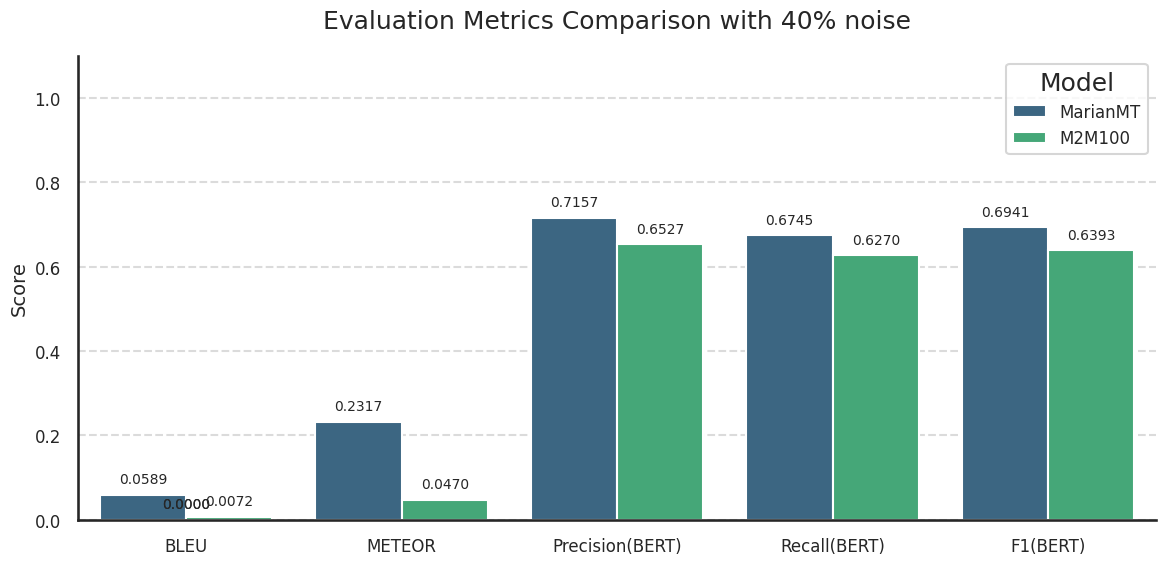

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.DataFrame({
    'Metric': marian_scores.keys(),
    'MarianMT': marian_scores.values(),
    'M2M100': m2m100_scores.values()
})

sns.set(style="white", context="talk")
palette = sns.color_palette("viridis", len(data))

plt.figure(figsize=(12, 6))
data_melted = data.melt(id_vars='Metric', var_name='Model', value_name='Score')
ax = sns.barplot(x='Metric', y='Score', hue='Model', data=data_melted, palette='viridis')

for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{bar.get_height():.4f}",
        ha='center', va='bottom', fontsize=10
    )

plt.title("Evaluation Metrics Comparison with 20-% noise", fontsize=18, pad=20)
plt.ylim(0, 1.1)
plt.ylabel("Score", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
plt.tight_layout()
plt.legend(title="Model", fontsize=12)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

noise_levels = np.linspace(0.0, 1.0, 11)
results = []

for noise in noise_levels:
    print(f"Evaluating with {int(noise * 100)}% noise...")

    data = retrieve_data(add_text_noise=True, noise_level=noise)
    val_data = data["validation"]

    src_texts = [ex["translation"]["de"] for ex in val_data]
    tgt_texts = [ex["translation"]["en"] for ex in val_data]

    marian_predictions = translate_with_model(marian_model, marian_tokenizer, src_texts)
    bert_score_marian = bertscore.compute(predictions=marian_predictions, references=[r[0] for r in references], lang="de")

    m2m_predictions = translate_with_model(m2m100_model, m2m100_tokenizer, src_texts)
    bert_score_m2m100 = bertscore.compute(predictions=m2m_predictions, references=[r[0] for r in references], lang="de")

    avg_score_marian = sum(bert_score_marian) / len(bert_score_marian)
    avg_score_m2m100 = sum(bert_score_m2m100) / len(bert_score_m2m100)

    results.append({'Noise Level': noise, 'Model': 'MarianMT', 'Score': avg_score_marian})
    results.append({'Noise Level': noise, 'Model': 'M2M100', 'Score': avg_score_m2m100})


Evaluating with 0% noise...


Translating: 100%|██████████| 188/188 [06:55<00:00,  2.21s/it]


Evaluating with 10% noise...


Map:   0%|          | 0/136918 [00:00<?, ? examples/s]

Translating: 100%|██████████| 188/188 [07:02<00:00,  2.25s/it]


Evaluating with 20% noise...


Map:   0%|          | 0/136918 [00:00<?, ? examples/s]

Translating: 100%|██████████| 188/188 [07:06<00:00,  2.27s/it]


Evaluating with 30% noise...


Map:   0%|          | 0/136918 [00:00<?, ? examples/s]

Translating: 100%|██████████| 188/188 [07:12<00:00,  2.30s/it]


Evaluating with 40% noise...


Map:   0%|          | 0/136918 [00:00<?, ? examples/s]

Translating: 100%|██████████| 188/188 [07:15<00:00,  2.32s/it]


Evaluating with 50% noise...


Map:   0%|          | 0/136918 [00:00<?, ? examples/s]

Translating: 100%|██████████| 188/188 [07:14<00:00,  2.31s/it]


Evaluating with 60% noise...


Map:   0%|          | 0/136918 [00:00<?, ? examples/s]

Translating: 100%|██████████| 188/188 [07:15<00:00,  2.32s/it]


Evaluating with 70% noise...


Map:   0%|          | 0/136918 [00:00<?, ? examples/s]

Translating: 100%|██████████| 188/188 [07:16<00:00,  2.32s/it]


Evaluating with 80% noise...


Map:   0%|          | 0/136918 [00:00<?, ? examples/s]

Translating: 100%|██████████| 188/188 [07:18<00:00,  2.33s/it]


Evaluating with 90% noise...


Map:   0%|          | 0/136918 [00:00<?, ? examples/s]

Translating: 100%|██████████| 188/188 [07:19<00:00,  2.34s/it]


Evaluating with 100% noise...


Map:   0%|          | 0/136918 [00:00<?, ? examples/s]

Translating: 100%|██████████| 188/188 [07:17<00:00,  2.33s/it]


In [ ]:
import matplotlib.ticker as mtick

df = pd.DataFrame(results)

df["Noise %"] = df["Noise Level"] * 100

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Noise %", y="Score", hue="Model", marker="o")

plt.title("BERT F1 Score vs Noise Level")
plt.xlabel("Noise Level (%)")
plt.ylabel("BERTScore F1")
plt.xticks(np.arange(0, 110, 10))
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()

plt.show()
